In [2]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
from torch import optim

In [9]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization
from nflows.transforms.dequantization import VariationalDequantization

In [5]:
# Generate some dist with 2 real and 2 discrete dims

# These are the probabilities to draw a particular label
x_prob_1 = np.random.rand(10)
x_prob_2 = np.random.rand(5)
p_labels_1 = x_prob_1/(np.sum(x_prob_1))
p_labels_2 = x_prob_2/(np.sum(x_prob_2))
p_cum_labels_1 = np.cumsum(p_labels_1)
p_cum_labels_2 = np.cumsum(p_labels_2)

def p(x,y):
    if np.all(x > 0) and np.all(x < 1) and x.shape == y.shape:
        return m.exp(-(x[0] + x[1])/2) * np.cos((x[0]*y[0] + x[1]*y[1])*m.pi)
    return 0

def generate(n):
    x = np.zeros((n,4))

    counter = 0
    while(counter < n):
        y = np.zeros(2)
        y[0] = np.argmax(r.random() < p_cum_labels_1)
        y[1] = np.argmax(r.random() < p_cum_labels_2)

        while(True):
            # Get a point
            x_trial = np.random.rand(2)
            if r.random() < p(x_trial, y):
                x[counter][0] = x_trial[0]
                x[counter][1] = x_trial[1]
                x[counter][2] = y[0]
                x[counter][3] = y[1]
                counter += 1
                break

    return x

In [13]:
num_layers = 5
base_dist_uniform = BoxUniform(torch.zeros(4), torch.ones(4))
base_dist_variational = BoxUniform(torch.zeros(4), torch.ones(4))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformDequantization(max_labels=torch.tensor([-1,-1,9,4])))
transforms_variational.append(VariationalDequantization(max_labels=torch.tensor([-1,-1,9,4]), rqs_hidden_features=15, rqs_flow_layers=2))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=4))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=4, 
        hidden_features=25,
        num_bins=5,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=4))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=4, 
        hidden_features=25,
        num_bins=5,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform)
flow_variational = Flow(transform_variational, base_dist_variational)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [6]:
x_data = torch.tensor(generate(1000000), dtype=torch.float32)

In [14]:
n_epochs = 10
batch_size = 500
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0])    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_data[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -flow_uniform.log_prob(inputs=batch_x).mean()
        loss_variational = -flow_variational.log_prob(inputs=batch_x).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)

=  9 batch =  1817 / 2000 loss_uniform =  -0.7403029132230503  loss_variational =  -0.7817435613948697
epoch =  9 batch =  1818 / 2000 loss_uniform =  -0.7402965563817648  loss_variational =  -0.7817671196361058
epoch =  9 batch =  1819 / 2000 loss_uniform =  -0.7402977827094688  loss_variational =  -0.7817923028171556
epoch =  9 batch =  1820 / 2000 loss_uniform =  -0.7402494554008756  loss_variational =  -0.7817611013467498
epoch =  9 batch =  1821 / 2000 loss_uniform =  -0.7402631834533959  loss_variational =  -0.7817735657595072
epoch =  9 batch =  1822 / 2000 loss_uniform =  -0.7402623753777974  loss_variational =  -0.781738509788995
epoch =  9 batch =  1823 / 2000 loss_uniform =  -0.7403110853277323  loss_variational =  -0.781780720607174
epoch =  9 batch =  1824 / 2000 loss_uniform =  -0.7403099550293726  loss_variational =  -0.7817720696656852
epoch =  9 batch =  1825 / 2000 loss_uniform =  -0.7403229822851207  loss_variational =  -0.7817803432843459
epoch =  9 batch =  1826 / 

In [16]:
n_sample = 1000000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample)
    x_variational = flow_variational.sample(n_sample)

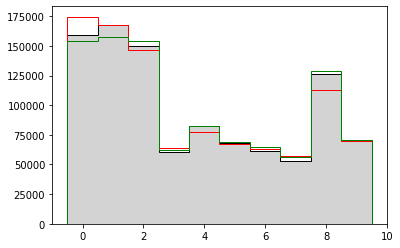

In [59]:
plt.hist(x_data.detach().numpy()[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins=np.linspace(-0.5, 9.5, 11))
plt.hist(x_uniform[:,2], edgecolor="red", histtype="step", bins = np.linspace(-0.5, 9.5, 11))
plt.hist(x_variational[:,2], edgecolor="green", histtype="step", bins = np.linspace(-0.5, 9.5, 11))
plt.show()

In [54]:
with torch.no_grad():
    x_uniform_dequantized, _ = flow_uniform._transform._transforms[0].forward(x_data)
    x_variational_dequantized, _ = flow_variational._transform._transforms[0].forward(x_data)

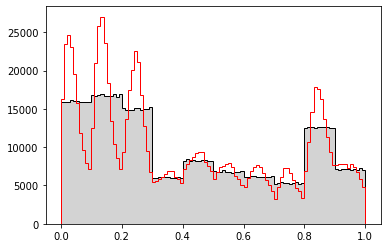

In [58]:
plt.hist(x_uniform_dequantized[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = 100)
plt.hist(x_variational_dequantized[:,2], edgecolor="red", histtype="step", bins = 100)
plt.show()